In [1]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

In [29]:
# User Inputs
basepath = Path('/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans')
sess_folder = Path('/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104')
event_dir = Path(r'/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104/experiment1/recording1/events/RHD_Rec_Controller-100.Rhythm Data/TTL')


# Get current OS and set paths dependent on working OS.
cur_system = platform.system()
cur_dir = Path(os.getcwd())

if cur_system == "Linux":  # For Linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path
    # Directories
    save_dir = Path('/home/kimqi/Documents/Analyses')

elif cur_system == "Windows":
    sys.path.extend([r'E:\Code\Repositories\NeuroPy'])  # NeuroPy Path

    # Data Directories
    cur_folder = Path(basepath).name
    save_dir = Path('E:\Analyses\Alignment')
    sess_folder = Path(r"E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka\2024-10-30_13-37-28\Record Node 104")
    event_dir = Path(r"E:\Data\PCDisruption\Strawberry\Stb_2024-10-30_Suzuka\2024-10-30_13-37-28\Record Node 104\experiment1\recording3\events\RHD_Rec_Controller-100.Rhythm Data\TTL")

cur_folder = Path(basepath).name
animal = basepath.parent.name
session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)

save_dir = Path(save_dir / animal / cur_folder)
plot_dir = Path(save_dir / 'Plots')


save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print(basepath)
print(cur_folder)
print(session_name)
print(save_dir)
print(plot_dir)
print(sess_folder)
print(event_dir)

/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans
Stb_2024-10-27_LeMans
Stb_LeMans
/home/kimqi/Documents/Analyses/Strawberry/Stb_2024-10-27_LeMans
/home/kimqi/Documents/Analyses/Strawberry/Stb_2024-10-27_LeMans/Plots
/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104
/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/2024-10-27_12-58-28/Record Node 104/experiment1/recording1/events/RHD_Rec_Controller-100.Rhythm Data/TTL


In [25]:
# Import NeuroPy Packages

# Analyses
from neuropy.analyses import oscillations
from neuropy.analyses.spkepochs import detect_pbe_epochs
from neuropy.analyses import placefields

# Core
from neuropy import core

from neuropy.core import Epoch
from neuropy.core import Neurons
from neuropy.core import Position
from neuropy.core.neurons import binned_pe_raster
from neuropy.core.neurons import pe_raster

from neuropy.core import BinnedSpiketrain
from neuropy.core import Shank, Probe, ProbeGroup

from neuropy.core.session import ProcessData

# IO
from neuropy.io import PhyIO

from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.io.openephysio import load_all_ttl_events

# Plotting
from neuropy.plotting import plot_probe
from neuropy.plotting import Fig
from neuropy.plotting import spikes
from neuropy.plotting.ratemaps import plot_ratemap

from neuropy.plotting.signals import plot_signal_traces

# Utils

from neuropy.utils import neurons_util
from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.utils.signal_process import filter_sig
from neuropy.utils import position_util

import neuropy.io.optitrackio as optiio
import neuropy.io.openephysio as oeio

In [27]:
settings_path = oeio.get_settings_file(sess_folder)
rec_df = oeio.create_sync_df(sess_folder)
rec_df

start time = 2024-10-27 12:58:28.836000-04:00
start time = 2024-10-27 13:04:07.234000-04:00
start time = 2024-10-27 13:08:56.940000-04:00
start time = 2024-10-27 13:50:37.149000-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2024-10-27 12:58:28.836000-04:00,start,0,0.000000,0,0.0000
1,0,2024-10-27 13:04:06.918100-04:00,stop,10142463,338.082100,422602,338.0816
2,1,2024-10-27 13:04:07.234000-04:00,start,10142464,338.082133,422603,338.0824
3,1,2024-10-27 13:08:53.476100-04:00,stop,18729727,624.324233,780405,624.3240
4,2,2024-10-27 13:08:56.940000-04:00,start,18729728,624.324267,780406,624.3248
5,2,2024-10-27 13:50:36.822633333-04:00,stop,93726207,3124.206900,3905258,3124.2064
6,3,2024-10-27 13:50:37.149000-04:00,start,93726208,3124.206933,3905259,3124.2072
7,3,2024-10-27 13:52:40.711633333-04:00,stop,97433087,3247.769567,4059711,3247.7688


In [32]:
#rec_start = rec_df.loc[4, "Datetime"]
opti_obj = optiio.OptitrackIO(basepath) # Load in optitrack position data from .csv
opti_obj.datetime_array = opti_obj.datetime_array.tz_localize("America/Detroit")
ttl_dict = oeio.load_ttl_events(event_dir)  # Load in TTL data
ttl_dict

/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-27_LeMans/Stb_2024-10-27_LeMans.csv


{'channel_states': array([ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1,
        -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
         1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1

In [6]:
start_datetime = rec_df.loc[4, 'Datetime']
t_start = rec_df.loc[4, 'dat_time']
t_stop = rec_df.loc[7, 'dat_time']
print(start_datetime)
print(t_start)
print(t_stop)

2024-10-30 13:45:38.213000-04:00
489.0538666666667
2919.193566666667


In [7]:
motive_ttl_channel = 2
motive_start_frame = ttl_dict["timestamps"][np.where(ttl_dict["channel_states"] == motive_ttl_channel)[0][0]]
motive_start_datetime = ttl_dict['start_time'] + pd.to_timedelta(motive_start_frame / ttl_dict["SR"], unit="sec")
print(motive_start_datetime)

2024-10-30 13:45:42.455166-04:00


In [8]:
opti_obj.remove_negatives(ref_time=start_datetime)

In [9]:
# Now subtract to get absolute time passed in seconds from recording start
motive_times_from_oe_rec_start = (opti_obj.datetime_array - start_datetime).total_seconds()
motive_times_from_oe_rec_start

Float64Index([         4.201,       4.234333,       4.267667,          4.301,
                    4.334333,       4.367667,          4.401,       4.434333,
                    4.467667,          4.501,
              ...
                    1913.701, 1913.734332999,    1913.767667,       1913.801,
                 1913.834333,    1913.867667,       1913.901,    1913.934333,
                 1913.967667,       1914.001],
             dtype='float64', length=57295)

In [10]:
#print(opti_obj.datetime_array)
print(len(opti_obj.datetime_array))
print(opti_obj.datetime_starts)
print(opti_obj.datetime_stops)
print(opti_obj.datetime_nframes)

57295
2024-10-30 13:45:42.414000-04:00
2024-10-30 14:17:32.214000-04:00
57295


In [11]:
sess = ProcessData(basepath)
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)
sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q=sess.phy.clu_q, shank_ids=sess.phy.shank_ids)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [12]:
pfs = sess.neurons.time_slice(t_start=t_start, t_stop=t_stop, zero_spike_times=True)
motive_sr = 30
pos2d = np.array([opti_obj.x, opti_obj.z]) # create a 2 x nframes array of x/y positions 

pos = Position(traces=pos2d, t_start=0, sampling_rate=motive_sr)
pos = position_util.linearize_position(pos)

C:\Users\bkimq\.conda\envs\NeuroPy\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\bkimq\.conda\envs\NeuroPy\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [13]:
print(pos.duration)
print(max(motive_times_from_oe_rec_start))

1909.8333333333333
1914.001


In [14]:
test_place_cells = placefields.Pf1D(neurons=pfs, position=pos, speed_thresh=2.5)


Speed Thresholding.png


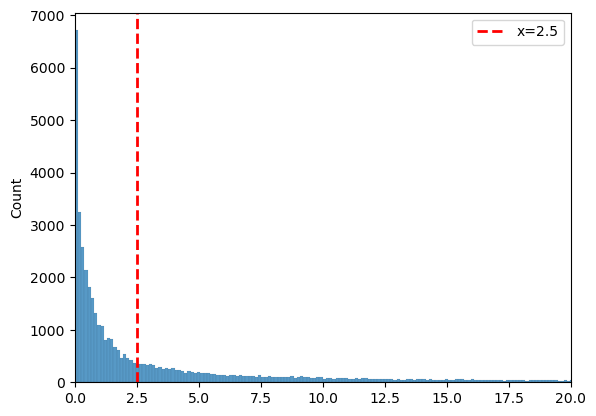

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace 'test_place_cells.speed' with your actual data)
speed_data = test_place_cells.speed  # Replace this with your actual data

# Plot histogram using seaborn
ax = sns.histplot(speed_data, bins=1000, kde=False, edgecolor="black")

# Draw vertical line at x=3
plt.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='x=2.5')

# Set x-axis limits
plt.xlim(0, 20)

# Add legend for clarity
plt.legend()

# Save the plot
plot_name = 'Speed Thresholding.png'
print(plot_name)
plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path

Averaged_Ratemaps.png


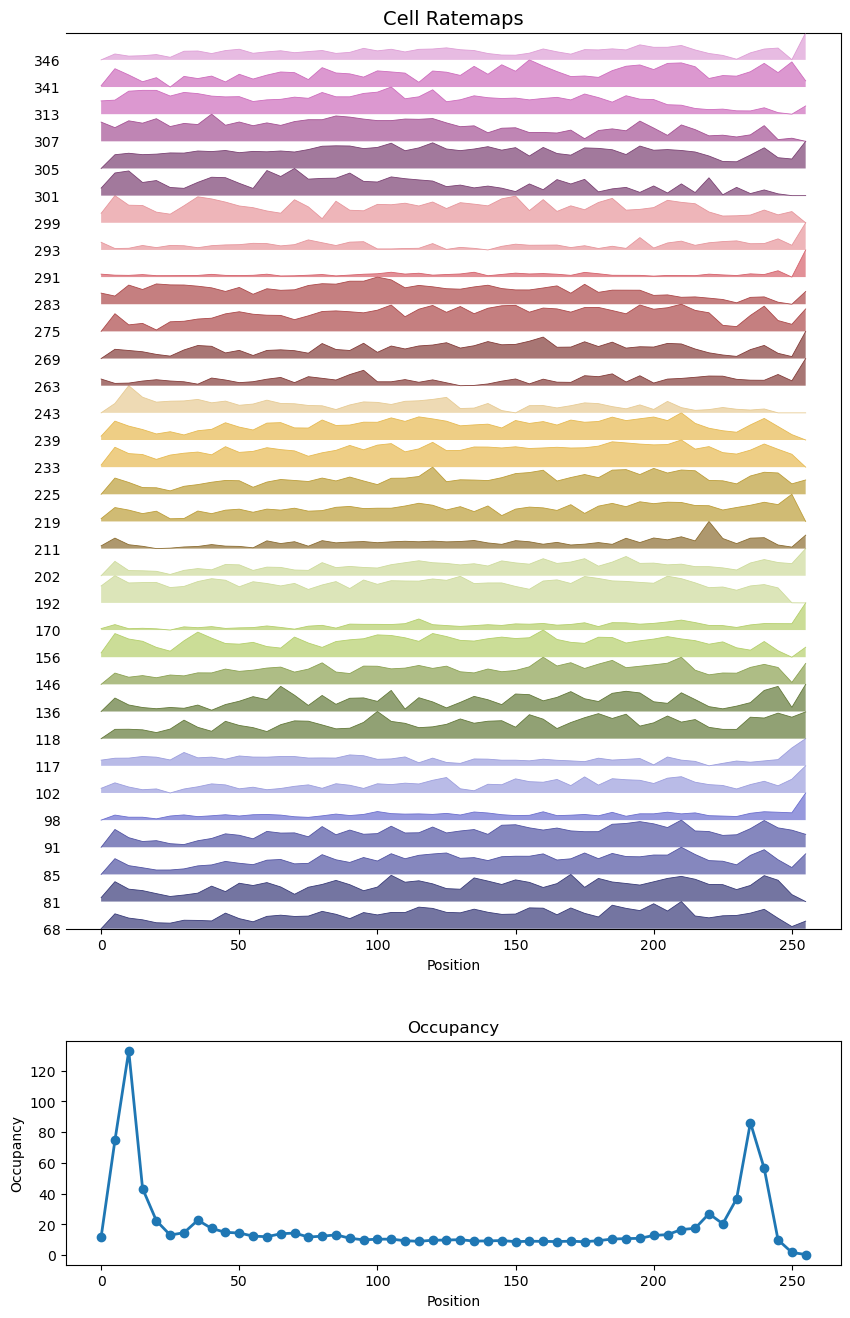

In [16]:
test_place_cells = placefields.Pf1D(neurons=pfs, position=pos, speed_thresh=2.5)

fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 1, figure=fig)

# Create an axes that spans 3 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans the first 3 rows in the grid
ax2 = fig.add_subplot(gs[3, 0])  # The 4th row for the bottom subplot

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)  # Increase space between subplots

# Set title and plot for the first subplot
ax1.set_title('Cell Ratemaps', fontsize=14)
plot_ratemap(test_place_cells, ax=ax1, normalize_tuning_curve=True, sortby=True)

# Scale x-axis values for the occupancy plot
scaled_x = [x * 5 for x in range(len(test_place_cells.occupancy))]
ax2.plot(scaled_x, test_place_cells.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

# Save the plot
plot_name = 'Averaged_Ratemaps.png'
print(plot_name)
plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
plt.show()

In [21]:
stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")
stim_epochs = Epoch(epochs=None, file=stim_epochs_file)
stim_epochs_df = stim_epochs.to_dataframe()
stim_epochs_df = stim_epochs_df[stim_epochs_df['start'] >= t_start]

In [34]:
stim_epochs_aligned_df

,start,stop,duration,time_between,label
188,727.451567,727.501567,0.050000,838.769067,
189,727.552333,727.602333,0.050000,0.050767,
190,727.652467,727.702467,0.050000,0.050133,
191,727.752600,727.802567,0.049967,0.050133,
192,727.854300,727.904300,0.050000,0.051733,
...,...,...,...,...,...
1057,1219.008200,1219.058200,0.050000,0.051533,
1058,1219.108533,1219.158533,0.050000,0.050333,
1059,1219.209533,1219.259533,0.050000,0.051000,
1060,1219.309300,1219.359300,0.050000,0.049767,


In [26]:
ctrlA_epoch = [0, stim_epochs_df['start'].min()- t_start - 5]
opto_epoch = [stim_epochs_df['start'].min()- t_start - 5, stim_epochs_df['stop'].max() -t_start + 5]
ctrlB_epoch = [stim_epochs_df['stop'].max() - t_start + 11, max(motive_times_from_oe_rec_start)]

print(ctrlA_epoch)
print(opto_epoch)
print(ctrlB_epoch)

[0, 722.4515666666666]
[722.4515666666666, 1224.4601666666667]
[1230.4601666666667, 1914.001]


In [107]:
ctrlA_cells = sess.neurons.time_slice(t_start=ctrlA_epoch[0], t_stop=ctrlA_epoch[1], zero_spike_times=True)
opto_cells = sess.neurons.time_slice(t_start=opto_epoch[0], t_stop=opto_epoch[1], zero_spike_times=True)
ctrlB_cells = sess.neurons.time_slice(t_start=ctrlB_epoch[0], t_stop=ctrlB_epoch[1], zero_spike_times=True)

motive_sr = 30
pos2d = np.array([opti_obj.x, opti_obj.z]) # create a 2 x nframes array of x/y positions 

pos = Position(traces=pos2d, t_start=0, sampling_rate=motive_sr)
pos = position_util.linearize_position(pos)

C:\Users\bkimq\.conda\envs\NeuroPy\Lib\site-packages\sklearn\manifold\_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\bkimq\.conda\envs\NeuroPy\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [56]:
stim_epochs_aligned_df = stim_epochs_df.copy()
stim_epochs_aligned_df['start'] = stim_epochs_aligned_df['start'] - t_start
stim_epochs_aligned_df['stop'] = stim_epochs_aligned_df['stop'] - t_start
stim_epochs_aligned_df['start'] = stim_epochs_aligned_df['start'] - opto_epoch[0] - 4.201
stim_epochs_aligned_df['stop'] = stim_epochs_aligned_df['stop'] - opto_epoch[0] - 4.201
stim_epochs_aligned_df['start'] = stim_epochs_aligned_df['start'] * 30
stim_epochs_aligned_df['stop'] = stim_epochs_aligned_df['stop'] * 30
stim_epochs_aligned_df

,start,stop,duration,time_between,label
188,23.970,25.470,0.050000,838.769067,
189,26.993,28.493,0.050000,0.050767,
190,29.997,31.497,0.050000,0.050133,
191,33.001,34.500,0.049967,0.050133,
192,36.052,37.552,0.050000,0.051733,
...,...,...,...,...,...
1057,14770.669,14772.169,0.050000,0.051533,
1058,14773.679,14775.179,0.050000,0.050333,
1059,14776.709,14778.209,0.050000,0.051000,
1060,14779.702,14781.202,0.050000,0.049767,


In [57]:
ctrlA_pos = pos.time_slice(t_start=ctrlA_epoch[0], t_stop=ctrlA_epoch[1],zero_times=True)
opto_pos = pos.time_slice(t_start=opto_epoch[0], t_stop=opto_epoch[1],zero_times=True)
ctrlB_pos = pos.time_slice(t_start=ctrlB_epoch[0], t_stop=ctrlB_epoch[1],zero_times=True)

In [58]:
print(opto_pos.n_frames / 30)
print(opto_pos.duration)

502.0
502.0


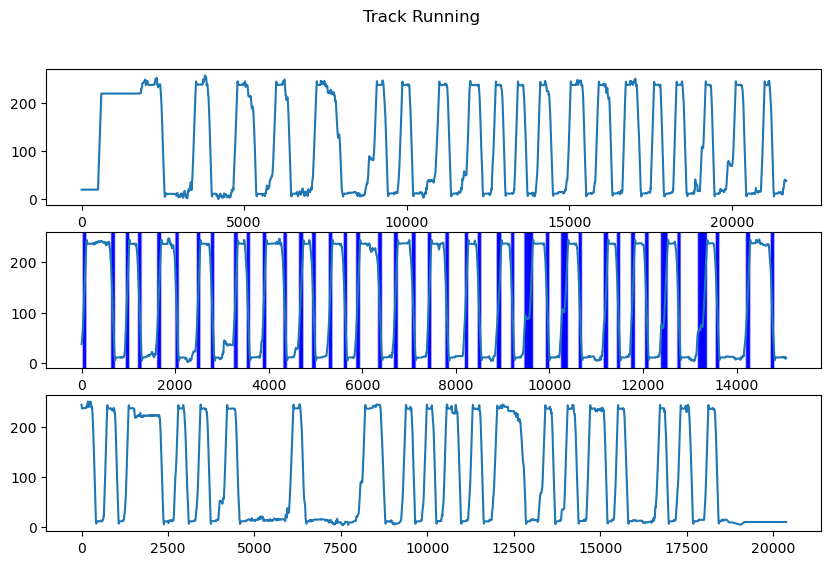

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(10,6))
fig.suptitle("Track Running")
ax[0].plot(ctrlA_pos.x)
ax[1].plot(opto_pos.x)
ax[2].plot(ctrlB_pos.x)

# Overlay blue bars only on ax[1] for start-stop durations
for start, stop in zip(stim_epochs_aligned_df['start'], stim_epochs_aligned_df['stop']):
    ax[1].axvspan(start, stop, color='blue', alpha=0.3)

In [68]:
ctrlA_pfs = placefields.Pf1D(neurons=ctrlA_cells, position=ctrlA_pos, speed_thresh=2.5)
opto_pfs = placefields.Pf1D(neurons=opto_cells, position=opto_pos, speed_thresh=2.5)
ctrlB_pfs = placefields.Pf1D(neurons=ctrlB_cells, position=ctrlB_pos, speed_thresh=2.5)

Opto_Ratemaps.png


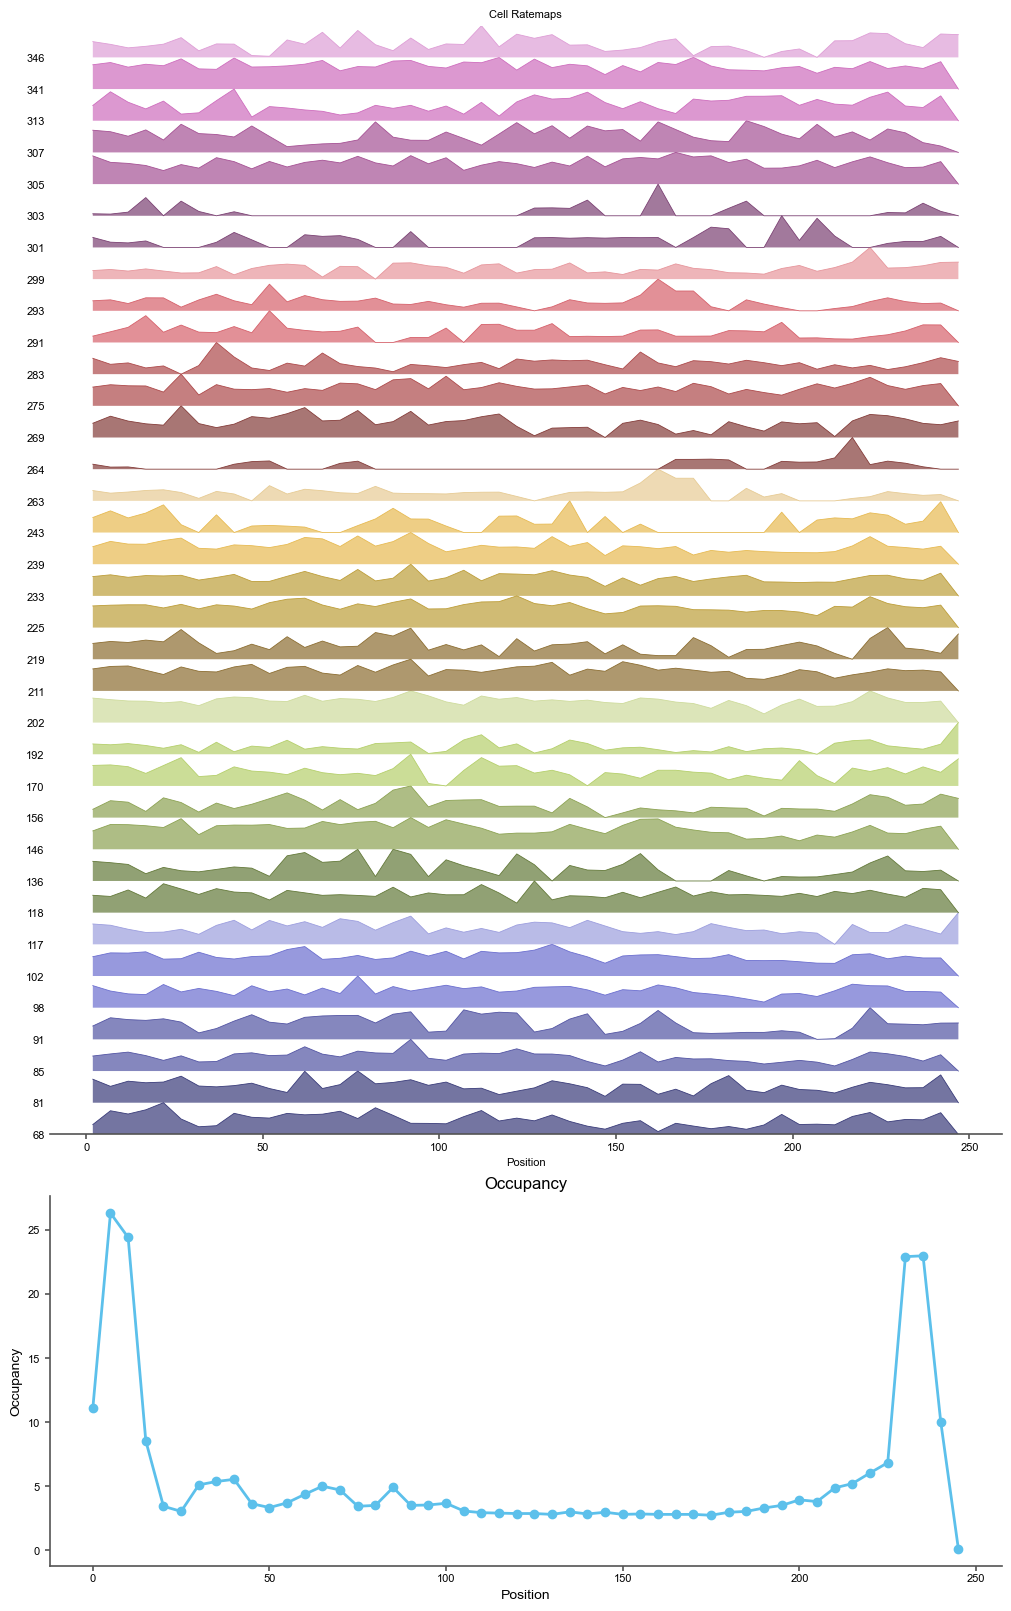

In [108]:
# Opto Condition Place Fields
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 1, figure=fig)

# Create an axes that spans 2 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans all rows in the first column
ax2 = fig.add_subplot(gs[3, 0])  # Top-right

ax1.set_title('Cell Ratemaps')
plot_ratemap(opto_pfs, ax=ax1, normalize_tuning_curve=True, sortby=True)

# Scale x-axis values for the occupancy plot
scaled_x = [x * 5 for x in range(len(opto_pfs.occupancy))]
ax2.plot(scaled_x, opto_pfs.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

# Save the plot
plot_name = 'Opto_Ratemaps.png'
print(plot_name)
plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
plt.show()

CtrlA_Ratemaps.png


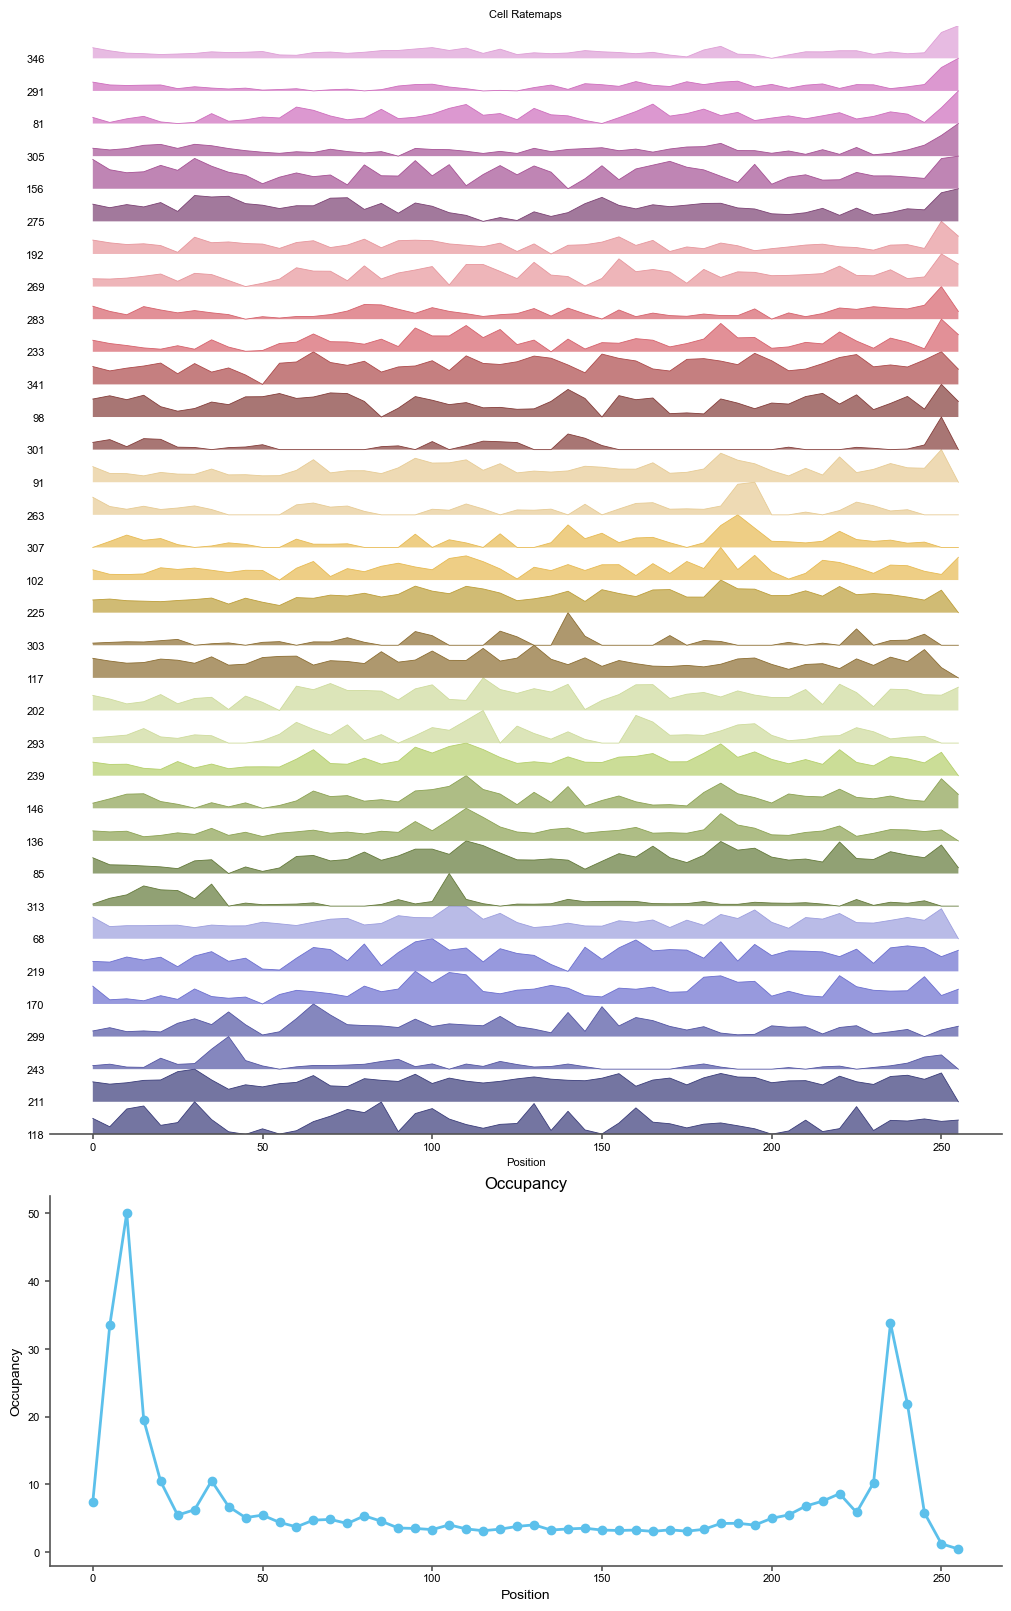

In [109]:
# Control Condition Place Fields
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 1, figure=fig)

# Create an axes that spans 2 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans all rows in the first column
ax2 = fig.add_subplot(gs[3, 0])  # Top-right

ax1.set_title('Cell Ratemaps')
plot_ratemap(ctrlA_pfs, ax=ax1, normalize_tuning_curve=True)

# Scale x-axis values for the occupancy plot
scaled_x = [x * 5 for x in range(len(ctrlA_pfs.occupancy))]
ax2.plot(scaled_x, ctrlA_pfs.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

# Save the plot
plot_name = 'CtrlA_Ratemaps.png'
print(plot_name)
plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
plt.show()

CtrlB_Ratemaps.png


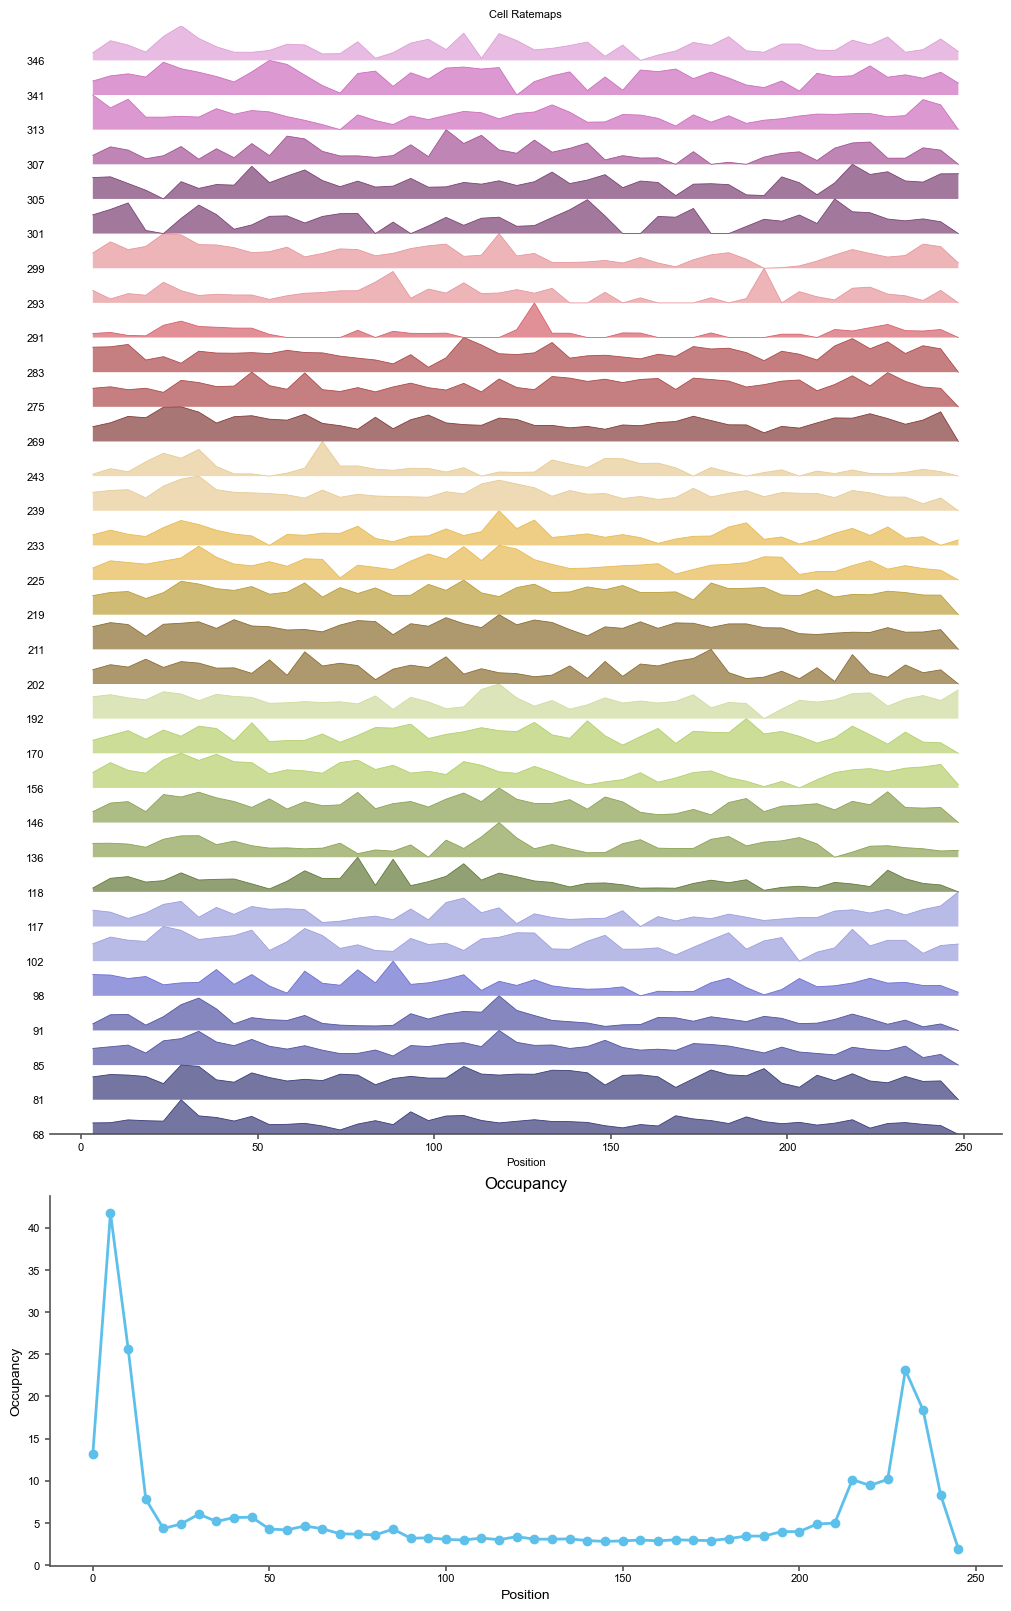

In [110]:
# Control Condition Place Fields
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4, 1, figure=fig)

# Create an axes that spans 2 rows in the first column
ax1 = fig.add_subplot(gs[0:3, 0])  # This spans all rows in the first column
ax2 = fig.add_subplot(gs[3, 0])  # Top-right

ax1.set_title('Cell Ratemaps')
plot_ratemap(ctrlB_pfs, ax=ax1, normalize_tuning_curve=True, sortby=True)

# Scale x-axis values for the occupancy plot
scaled_x = [x * 5 for x in range(len(ctrlB_pfs.occupancy))]
ax2.plot(scaled_x, ctrlB_pfs.occupancy, marker='o', linestyle='-', linewidth=2)
ax2.set_title("Occupancy", fontsize=12)
ax2.set_xlabel("Position", fontsize=10)
ax2.set_ylabel("Occupancy", fontsize=10)

# Save the plot
plot_name = 'CtrlB_Ratemaps.png'
print(plot_name)
plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
plt.show()

In [115]:
plot_dir = plot_dir / 'PFRasters'
plot_dir

WindowsPath('E:/Analyses/Alignment/Strawberry/Stb_2024-10-30_Suzuka/Plots/PFRasters')

In [116]:
for i in range(opto_pfs.n_neurons):
    fig, ax = plt.subplots(2,1, figsize=(10,5))
    opto_pfs.plot_ratemap_w_raster(ind=i,ax=ax)
    plot_name = f'Opto_Cell_{i}.png'
    print(plot_name)
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()

Opto_Cell_0.png
Opto_Cell_1.png
Opto_Cell_2.png
Opto_Cell_3.png
Opto_Cell_4.png
Opto_Cell_5.png
Opto_Cell_6.png
Opto_Cell_7.png
Opto_Cell_8.png
Opto_Cell_9.png
Opto_Cell_10.png
Opto_Cell_11.png
Opto_Cell_12.png
Opto_Cell_13.png
Opto_Cell_14.png
Opto_Cell_15.png
Opto_Cell_16.png
Opto_Cell_17.png
Opto_Cell_18.png
Opto_Cell_19.png
Opto_Cell_20.png
Opto_Cell_21.png
Opto_Cell_22.png
Opto_Cell_23.png
Opto_Cell_24.png
Opto_Cell_25.png
Opto_Cell_26.png
Opto_Cell_27.png
Opto_Cell_28.png
Opto_Cell_29.png
Opto_Cell_30.png
Opto_Cell_31.png
Opto_Cell_32.png
Opto_Cell_33.png
Opto_Cell_34.png


In [117]:
for i in range(ctrlA_pfs.n_neurons):
    fig, ax = plt.subplots(2,1, figsize=(10,5))
    ctrlA_pfs.plot_ratemap_w_raster(ind=i,ax=ax)
    plot_name = f'CtrlA_Cell_{i}.png'
    print(plot_name)
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()

CtrlA_Cell_0.png
CtrlA_Cell_1.png
CtrlA_Cell_2.png
CtrlA_Cell_3.png
CtrlA_Cell_4.png
CtrlA_Cell_5.png
CtrlA_Cell_6.png
CtrlA_Cell_7.png
CtrlA_Cell_8.png
CtrlA_Cell_9.png
CtrlA_Cell_10.png
CtrlA_Cell_11.png
CtrlA_Cell_12.png
CtrlA_Cell_13.png
CtrlA_Cell_14.png
CtrlA_Cell_15.png
CtrlA_Cell_16.png
CtrlA_Cell_17.png
CtrlA_Cell_18.png
CtrlA_Cell_19.png
CtrlA_Cell_20.png
CtrlA_Cell_21.png
CtrlA_Cell_22.png
CtrlA_Cell_23.png
CtrlA_Cell_24.png
CtrlA_Cell_25.png
CtrlA_Cell_26.png
CtrlA_Cell_27.png
CtrlA_Cell_28.png
CtrlA_Cell_29.png
CtrlA_Cell_30.png
CtrlA_Cell_31.png
CtrlA_Cell_32.png
CtrlA_Cell_33.png


In [118]:
for i in range(ctrlB_pfs.n_neurons):
    fig, ax = plt.subplots(2,1, figsize=(10,5))
    ctrlB_pfs.plot_ratemap_w_raster(ind=i,ax=ax)
    plot_name = f'CtrlB_Cell_{i}.png'
    print(plot_name)
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()

CtrlB_Cell_0.png
CtrlB_Cell_1.png
CtrlB_Cell_2.png
CtrlB_Cell_3.png
CtrlB_Cell_4.png
CtrlB_Cell_5.png
CtrlB_Cell_6.png
CtrlB_Cell_7.png
CtrlB_Cell_8.png
CtrlB_Cell_9.png
CtrlB_Cell_10.png
CtrlB_Cell_11.png
CtrlB_Cell_12.png
CtrlB_Cell_13.png
CtrlB_Cell_14.png
CtrlB_Cell_15.png
CtrlB_Cell_16.png
CtrlB_Cell_17.png
CtrlB_Cell_18.png
CtrlB_Cell_19.png
CtrlB_Cell_20.png
CtrlB_Cell_21.png
CtrlB_Cell_22.png
CtrlB_Cell_23.png
CtrlB_Cell_24.png
CtrlB_Cell_25.png
CtrlB_Cell_26.png
CtrlB_Cell_27.png
CtrlB_Cell_28.png
CtrlB_Cell_29.png
CtrlB_Cell_30.png
CtrlB_Cell_31.png
